# BOS - HTW Konstanz Messung MTF SS 21 Gruppe 2, Bartel, Stehle, Gebekken

In [8]:
#Bibliotheken importieren
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio
from scipy.optimize import curve_fit
import os
%matplotlib inline

### Aufgabe 4: Defektpixel

In [9]:
#Parametrisierung

#Pixelauflösung
n = 3840 #Breite
m = 2748 #Höhe

n_2 = 3830
#Bildanzahl
l = 16

#Verstärkung (aus Aufgabe 2):
k = 0.09

In [10]:
#Dateinamen:
data_white = ["hell01","hell02","hell03","hell04","hell05","hell06","hell07","hell08","hell09","hell10","hell11","hell12","hell13","hell14","hell15","hell16"] #Dateinamen
data_dark = ["dunkel01","dunkel02","dunkel03","dunkel04","dunkel05","dunkel06","dunkel07","dunkel08","dunkel09","dunkel10","dunkel11","dunkel12","dunkel13","dunkel14","dunkel15","dunkel16"] #Dateinamen

In [11]:
#Hell und Dunkelbilder mitteln:

sum_white = np.zeros((m,n))
sum_dark = np.zeros((m,n))

for i in range(l):
    basepath=r"C:\Users\Milan\Documents\GitHub\optik_mme\u-kugel\neu\raeumliche_inhomo\hell"
    #print(os.path.join(basepath, data_white[i]) + ".bmp")
    
    sum_white += imageio.imread(os.path.join(basepath, data_white[i]) + ".bmp").astype('float32')
    basepath=r"C:\Users\Milan\Documents\GitHub\optik_mme\u-kugel\neu\raeumliche_inhomo\dunkel"
    sum_dark += imageio.imread(os.path.join(basepath, data_dark[i]) + ".bmp").astype('float32')
    
y_white = sum_white[:,10:]/l
y_dark = sum_dark[:,10:]/l

In [12]:
#Mittelwert bilden

mean_white = np.mean(y_white)
mean_dark = np.mean(y_dark)

In [13]:
#Varianz bilden:

var_white = (1/(m*n_2-1))*np.sum((y_white-mean_white)**2)
var_dark = (1/(m*n_2-1))*np.sum((y_dark-mean_dark)**2)

In [14]:
#Zeitliches Rauschen:

var_t_white = np.zeros((m,n_2))
var_t_dark = np.zeros((m,n_2))

for i in range(l):
    basepath=r"C:\Users\Milan\Documents\GitHub\optik_mme\u-kugel\neu\raeumliche_inhomo\hell"
    img = imageio.imread(os.path.join(basepath, data_white[i]) + ".bmp").astype('float32')[:,10:]
    var_t_white += (1/(l-1))*((img-y_white)**2)
    basepath=r"C:\Users\Milan\Documents\GitHub\optik_mme\u-kugel\neu\raeumliche_inhomo\dunkel"
    img2 = imageio.imread(os.path.join(basepath, data_dark[i])+ ".bmp").astype('float32')[:,10:]
    var_t_dark += (1/(l-1))*((img2-y_dark)**2)
    

In [15]:
#Durchschnitt aller Pixel:

var_white_temp_stack = np.mean(var_t_white)
var_dark_temp_stack = np.mean(var_t_dark)

In [16]:
#Korrigierte Varianz:

var_white_spat = var_white-(var_white_temp_stack/l)
var_dark_spat = var_dark-(var_dark_temp_stack/l)

In [17]:
#Bildung DSNU / PRNU:

dsnu_1288 = np.sqrt(var_dark)/k
prnu_1288 = (np.sqrt(var_white-var_dark)/(mean_white-mean_dark))

dsnu_spat = np.sqrt(var_dark_spat)/k
prnu_spat = (np.sqrt(var_white_spat-var_dark_spat)/(mean_white-mean_dark))

std_dark_temp = np.sqrt(var_dark_temp_stack)
std_white_temp = np.sqrt(var_white_temp_stack)

In [18]:
#Spektogramm:

y_dark_spec = y_dark-np.mean(y_dark)
y_white_spec = y_white-y_dark-np.mean(y_white-y_dark)


#diskrete fft horizontal
#Dunkelbild:
fft_h_dark = np.fft.fft(y_dark_spec,axis=1) / np.sqrt(n_2)
#Hellbild:
fft_h_white = np.fft.fft(y_white_spec,axis=1) / np.sqrt(n_2)

#diskrete fft vertical
#Dunkelbild:
fft_v_dark = np.fft.fft(y_dark_spec,axis=0) / np.sqrt(m)
#Hellbild:
fft_v_white = np.fft.fft(y_white_spec,axis=0) / np.sqrt(m)


#Amplitudenspektrum horizontal
#Dunkelbild:
fft_h_dark_amp = np.real(np.sqrt(np.sum(fft_h_dark*np.conjugate(fft_h_dark),axis=0)/m))
#Hellbild:
fft_h_white_amp = np.real(np.sqrt(np.sum(fft_h_white*np.conjugate(fft_h_white),axis=0)/m))

#Amplitudenspektrum vertikal
#Dunkelbild:
fft_v_dark_amp = np.real((np.sum(fft_v_dark*np.conjugate(fft_v_dark),axis=1)/n_2))
#Hellbild:
fft_v_white_amp = np.real((np.sum(fft_v_white*np.conjugate(fft_v_white),axis=1)/n_2))

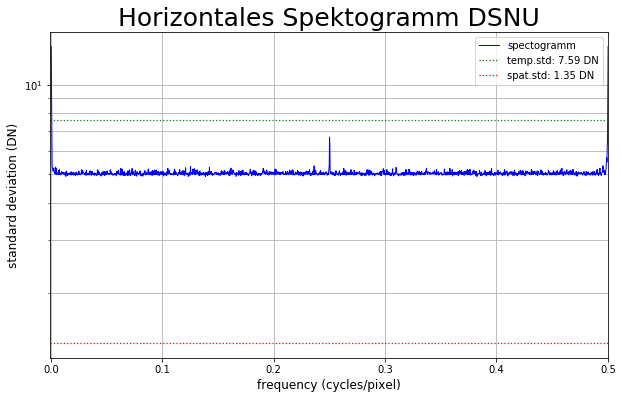

In [19]:
#Plotten Horizontales Spektogramm DSNU

#X-Achse definieren
spec_x_h = np.arange(1,n_2+1,1)/n_2
spec_x_v = np.arange(1,m+1,1)/m

#Voreinstellungen
fig = plt.figure(figsize=(10, 6))
plt.yscale("log")

#Data
plt.plot(spec_x_h,np.sqrt(fft_h_dark_amp)/k,'b',linewidth=1)
#temp
plt.axhline(y = std_dark_temp/k, color = 'green',linewidth=1.25,linestyle='dotted')
#spatial
plt.axhline(y = dsnu_spat, color = 'red',linewidth=1.25,linestyle='dotted')

#Einstellungen
plt.title("Horizontales Spektogramm DSNU",fontsize=25)
plt.xlabel('frequency (cycles/pixel)',fontsize=12)
plt.ylabel('standard deviation (DN)',fontsize=12)
plt.grid(True, which="both")
plt.legend(['spectogramm',f'temp.std: {round(std_dark_temp/k,2)} DN',f'spat.std: {round(dsnu_spat,2)} DN'],loc = 'upper right')
plt.xlim(-0.001,0.5)
plt.savefig("Horizontales_Spektogramm_DSNU",dpi=200)  

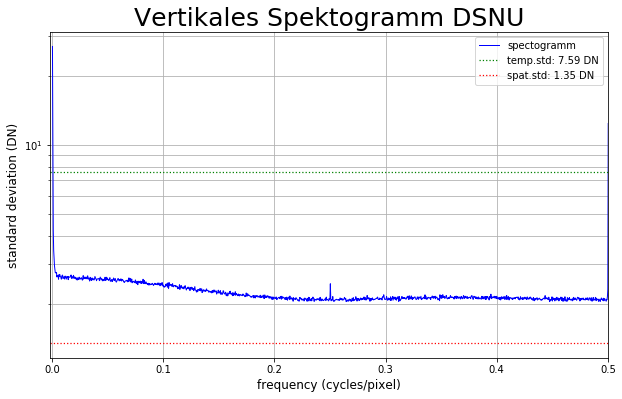

In [20]:
#Plotten Vertikales Spektogramm DSNU

#Voreinstellungen
fig = plt.figure(figsize=(10, 6))
plt.yscale("log")

#Data
plt.plot(spec_x_v,np.sqrt(fft_v_dark_amp)/k,'b',linewidth=1)
#temp
plt.axhline(y = std_dark_temp/k, color = 'green',linewidth=1.25,linestyle='dotted')
#spatial
plt.axhline(y = dsnu_spat, color = 'red',linewidth=1.25,linestyle='dotted')

#Einstellungen
plt.title("Vertikales Spektogramm DSNU",fontsize=25)
plt.xlabel('frequency (cycles/pixel)',fontsize=12)
plt.ylabel('standard deviation (DN)',fontsize=12)
plt.grid(True, which="both")
plt.legend(['spectogramm',f'temp.std: {round(std_dark_temp/k,2)} DN',f'spat.std: {round(dsnu_spat,2)} DN'],loc = 'upper right')
plt.xlim(-0.002,0.5)
plt.savefig("Vertikales_Spektogramm_DSNU",dpi=200)  

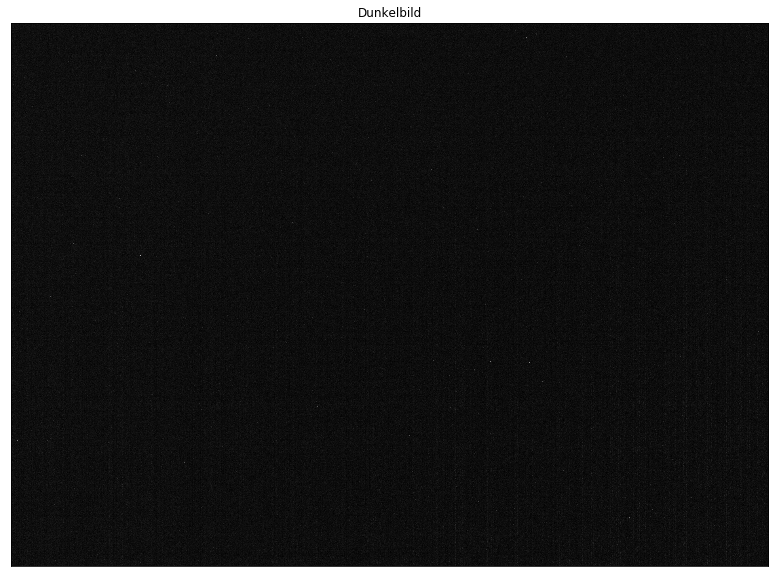

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(y_dark,cmap="gray")
plt.xticks([]), plt.yticks([])
plt.title('Dunkelbild') 
plt.show()
plt.imsave('Dunkelbild.png',(y_dark/y_dark.max()),cmap="gray")

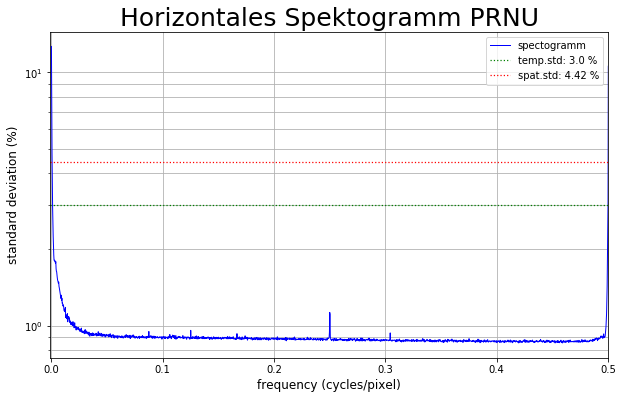

In [22]:
#Plotten Horizontales Spektogramm PRNU

#Voreinstellungen
fig = plt.figure(figsize=(10, 6))
plt.yscale("log")

#Data
plt.plot(spec_x_h,100*np.sqrt(fft_h_white_amp)/(mean_white-mean_dark),'b',linewidth=1)
#temp
plt.axhline(y = 100*np.sqrt(var_white_temp_stack-var_dark_temp_stack)/(mean_white-mean_dark), color = 'green',linewidth=1.25,linestyle='dotted')
#spatial
plt.axhline(y = 100*prnu_spat, color = 'red',linewidth=1.25,linestyle='dotted')

#Einstellungen
plt.title("Horizontales Spektogramm PRNU",fontsize=25)
plt.xlabel('frequency (cycles/pixel)',fontsize=12)
plt.ylabel('standard deviation (%)',fontsize=12)
plt.grid(True, which="both")
plt.legend(['spectogramm',f'temp.std: {round(100*np.sqrt(var_white_temp_stack-var_dark_temp_stack)/(mean_white-mean_dark),2)} %',f'spat.std: {round(100*prnu_spat,2)} %'],loc = 'upper right')
plt.xlim(-0.001,0.5)
plt.savefig("Horizontales_Spektogramm_PRNU",dpi=200)  

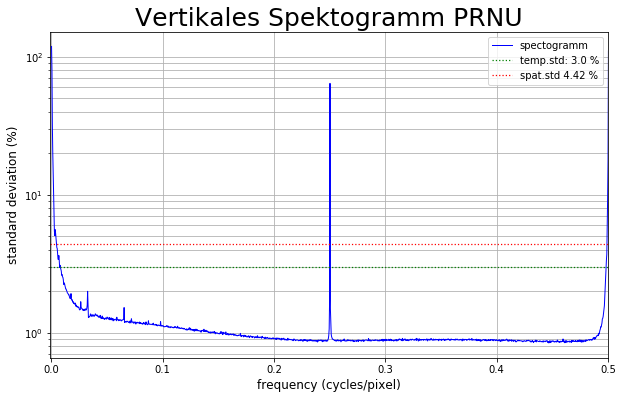

In [23]:
#Plotten Vertikal Spektogramm PRNU

#Voreinstellungen
fig = plt.figure(figsize=(10, 6))
plt.yscale("log")

#Data
plt.plot(spec_x_v,100*np.sqrt(fft_v_white_amp)/(mean_white-mean_dark),'b',linewidth=1)
#temp
plt.axhline(y = 100*np.sqrt(var_white_temp_stack-var_dark_temp_stack)/(mean_white-mean_dark), color = 'green',linewidth=1.25,linestyle='dotted')
#spatial
plt.axhline(y = 100*prnu_spat, color = 'red',linewidth=1.25,linestyle='dotted')

#Einstellungen
plt.title("Vertikales Spektogramm PRNU",fontsize=25)
plt.xlabel('frequency (cycles/pixel)',fontsize=12)
plt.ylabel('standard deviation (%)',fontsize=12)
plt.grid(True, which="both")
plt.legend(['spectogramm',f'temp.std: {round(100*np.sqrt(var_white_temp_stack-var_dark_temp_stack)/(mean_white-mean_dark),2)} %',f'spat.std {round(100*prnu_spat,2)} %'],loc = 'upper right')
plt.xlim(-0.001,0.5)
plt.savefig("Vertikales_Spektogramm_PRNU",dpi=200)  

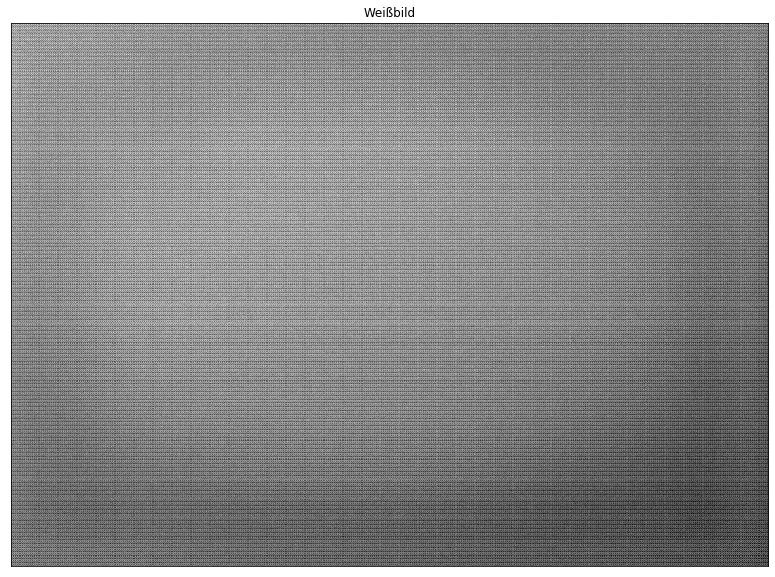

In [24]:
plt.figure(figsize=(20,10))
plt.imshow(y_white/y_white.max(),cmap="gray")
plt.xticks([]), plt.yticks([])
plt.title('Weißbild') 
plt.show()
plt.imsave('Weißbild.png',(y_white/y_white.max()),cmap="gray",dpi=100000)

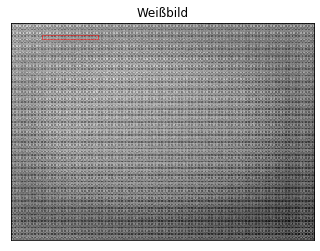

In [25]:
fig, ax = plt.subplots()
ax.imshow(y_white/y_white.max(),cmap="gray"),plt.title('Weißbild')
rect = patches.Rectangle((400, 150), 700, 50, linewidth=0.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.xticks([]), plt.yticks([])
fig.figsize=(20,10)
plt.show
plt.savefig('Weißbild_ausschnitt.png',dpi=500)

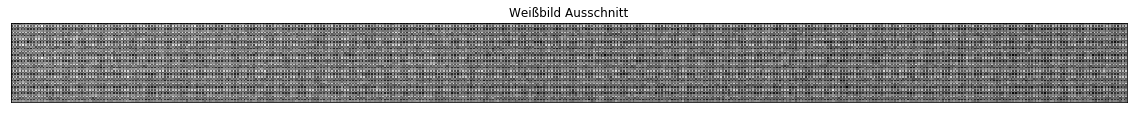

In [26]:
y_white_z = y_white[150:200,400:1100]

plt.figure(figsize=(20,10))
plt.imshow(y_white_z/y_white_z.max(),cmap="gray")
plt.xticks([]), plt.yticks([])
plt.title('Weißbild Ausschnitt') 
plt.show()
plt.imsave('Weißbild_ausschnitt_groß.png',(y_white_z/y_white_z.max()),cmap="gray",dpi=100000)

In [ ]:
#Hochpassfilterung PRNU:

y_wd = y_white-y_dark
kernel = np.ones((5,5),np.float32)/25
y_white_hp = cv2.filter2D(y_wd,-1,kernel)
y_box = y_wd-y_white_hp

#Bild anzeigen
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(y_wd,cmap="gray"),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(y_box,cmap="gray"),plt.title('Boxgefiltert')
plt.xticks([]), plt.yticks([])
plt.show()

#Bilder speichern
plt.imsave('Boxgefiltert.png',y_box,cmap="gray")

In [ ]:
#Hochpassfilterung DSNU:

y_dark_hp = cv2.filter2D(y_dark,-1,kernel)
y_box_d = y_dark-y_dark_hp

#Bild anzeigen
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(y_dark,cmap="gray"),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(y_box_d,cmap="gray"),plt.title('Boxgefiltert')
plt.xticks([]), plt.yticks([])
plt.show()

#Bilder speichern
plt.imsave('Boxgefiltert DSNU.png',y_box,cmap="gray")

In [ ]:
#Berechnen Histogramm DSNU:
bins = 230

#Maximal & Minimalwert & Mittelwert
y_min = np.min(y_dark)
y_max = np.max(y_dark)
y_mean = np.mean(y_dark)


#Bins berechnen
I = int((l*(y_max-y_min))/bins)+1
Q = int(l*(y_max-y_min)/I)+1
q = np.arange(0,Q,1)
dev_mean_dark = (y_min+((I-1)/(2*l))+(q*I/l))-y_mean

hist_dark = np.zeros(Q)

for i in range(m):
        for j in range(n_2):         
            q = int(l*(y_dark[i,j]-y_min)/I)
            hist_dark[q] +=1

In [ ]:
#Berechnen Histogramm DSNU Boxgefiltert:
bins = 230

#Maximal & Minimalwert & Mittelwert
y_min = np.min(y_box_d)
y_max = np.max(y_box_d)
y_mean = np.mean(y_box_d)

#Bins berechnen
I = int((l*(y_max-y_min))/bins)+1
Q = int(l*(y_max-y_min)/I)+1
q = np.arange(0,Q,1)
dev_mean_dark_b = (y_min+((I-1)/(2*l))+(q*I/l))-y_mean

hist_dark_b = np.zeros(Q)

for i in range(m):
        for j in range(n_2):         
            q = int(l*(y_box_d[i,j]-y_min)/I)
            hist_dark_b[q] +=1

In [ ]:
#Histogramm PRNU:
bins = 2**8

#Maximal & Minimalwert & Mittelwert
y_min = np.min(y_box)
y_max = np.max(y_box)
y_mean = np.mean(y_box)

#Bins berechnen
I = int((l*(y_max-y_min))/bins)+1
Q = int(l*(y_max-y_min)/I)+1
q = np.arange(0,Q,1)
dev_mean_white = (y_min+((I-1)/(2*l))+(q*I/l))-y_mean
dev_mean_white_per = 100*dev_mean_white/np.mean(y_wd)

hist_white = np.zeros(Q)

for i in range(m):
        for j in range(n_2):         
            q = int(l*(y_box[i,j]-y_min)/I)
            hist_white[q] +=1

In [ ]:
#Threshold DSNU 
hot_thr_dev = 1170

In [ ]:
#Plotten Histogramm DSNU
fig = plt.figure(figsize=(10, 6))
plt.yscale("log")

#Data
plt.plot(dev_mean_dark,hist_dark,'k',linewidth=1)
#threshold
plt.axvline(x = hot_thr_dev, color = 'red',linewidth=1.25,linestyle='dotted')

#Einstellungen
plt.legend(['Histogram','threshold'],loc = 'upper right')
plt.title("Logarithmic Histogram DSNU",fontsize=25)
plt.xlabel('Deviation from mean (DN)',fontsize=12)
plt.ylabel('Number of pixels/bin',fontsize=12)
plt.grid(True, which="both",linestyle = 'dotted')
plt.savefig("Histogramm DSNU",dpi=200)  


In [ ]:
#Hotpixel:

hot_th = hot_thr_dev+np.mean(y_dark)
hot = np.argwhere(y_dark>hot_th)

#Bild anzeigen
plt.figure(1,figsize=(20,10))

for i in hot:
    plt.plot(i[1],i[0],'o',color='none',mec ='red')
   
plt.imshow(y_dark,cmap="gray"),plt.title('Hotpixel')
plt.xticks([]), plt.yticks([])
plt.show

#Bilder speichern
plt.savefig('Hotpixel.png',dpi=500)

In [ ]:
#Threshold DSNU boxgefiltert
hot_thr_dev_b = 870

In [ ]:
#Plotten Histogramm DSNU Boxgefiltert
fig = plt.figure(figsize=(10, 6))
plt.yscale("log")

#Data
plt.plot(dev_mean_dark_b,hist_dark_b,'k',linewidth=1)
#threshold
plt.axvline(x = hot_thr_dev_b, color = 'red',linewidth=1.25,linestyle='dotted')

#Einstellungen
plt.legend(['Histogram','threshold'],loc = 'upper right')
plt.title("Logarithmic Histogram DSNU boxgefiltert",fontsize=25)
plt.xlabel('Deviation from mean (DN)',fontsize=12)
plt.ylabel('Number of pixels/bin',fontsize=12)
plt.grid(True, which="both",linestyle = 'dotted')
plt.savefig("Histogramm DSNU boxgefiltert",dpi=200)  


In [ ]:
#Hotpixel:

hot_th = hot_thr_dev_b+np.mean(y_box_d)
hot = np.argwhere(y_box_d>hot_th)

#Bild anzeigen
plt.figure(1,figsize=(20,10))

for i in hot:
    plt.plot(i[1],i[0],'o',color='none',mec ='red')
   
plt.imshow(y_box_d,cmap="gray"),plt.title('Hotpixel')
plt.xticks([]), plt.yticks([])
plt.show

#Bilder speichern
plt.savefig('Hotpixel boxgefiltert.png',dpi=500)

In [ ]:
#Threshold PRNU boxgefiltert
dead_thr_per = -3.1

In [ ]:
#Plotten Histogramm PRNU
fig = plt.figure(figsize=(10, 6))
plt.yscale("log")

#Data
plt.plot(dev_mean_white_per,hist_white,'k',linewidth=1)
#threshold
plt.axvline(x = dead_thr_per, color = 'red',linewidth=1.25,linestyle='dotted')

#Einstellungen
plt.legend(['Histogram','threshold'],loc = 'upper right')
plt.title("Logarithmic Histogram PRNU",fontsize=25)
plt.xlabel('Deviation from mean (%)',fontsize=12)
plt.ylabel('Number of pixels/bin',fontsize=12)
plt.grid(True, which="both",linestyle = 'dotted')
plt.savefig("Histogramm PRNU",dpi=200) 

In [ ]:
#Deadpixel:

dead_thr_dev = dead_thr_per*np.mean(y_wd)/100
dead_thr = dead_thr_dev+np.mean(y_box)


dead = np.argwhere(y_box<dead_thr)

#Bild anzeigen
plt.figure(2,figsize=(20,10))

for i in dead:
    plt.plot(i[1],i[0],'o',color='none',mec ='red')
   
plt.imshow(y_box,cmap="gray"),plt.title('Deadpixel')
plt.xticks([]), plt.yticks([])
plt.show

#Bilder speichern
plt.savefig('Deadpixel.png',dpi=500)

### Aufgabe 5: Radiometrische kalibrierung

In [ ]:
#Parametrisierung

#Pixelauflösung
n = 1600 #Breite
m = 1200 #Höhe

#Bildanzahl
l = 16

#Belichtungszeiten
t_d1 = 0.02  #Dunkelbild 2 ms
t_d2 = 200   #Dunkelbild 200 ms 
t_exp = 135   #Belichtungszeit Testbild ms
t_w = 1.1    #Hellbild ms

In [ ]:
#Dateinamen:
data_white = ["H_1.1_1","H_1.1_2","H_1.1_3","H_1.1_4","H_1.1_5","H_1.1_6","H_1.1_7","H_1.1_8","H_1.1_9","H_1.1_10","H_1.1_11","H_1.1_12","H_1.1_13","H_1.1_14","H_1.1_15","H_1.1_16",]
data_dark_002 = ["D_0.02_1","D_0.02_2","D_0.02_3","D_0.02_4","D_0.02_5","D_0.02_6","D_0.02_7","D_0.02_8","D_0.02_9","D_0.02_10","D_0.02_11","D_0.02_12","D_0.02_13","D_0.02_14","D_0.02_15","D_0.02_16"]
#data_dark_03 = ["D_0.3_1","D_0.3_2","D_0.3_3","D_0.3_4","D_0.3_5","D_0.3_6","D_0.3_7","D_0.3_8","D_0.3_9","D_0.3_10","D_0.3_11","D_0.3_12","D_0.3_13","D_0.3_14","D_0.3_15","D_0.3_16",]
data_dark_200 = ["D_200_1","D_200_2","D_200_3","D_200_4","D_200_5","D_200_6","D_200_7","D_200_8","D_200_9","D_200_10","D_200_11","D_200_12","D_200_13","D_200_14","D_200_15","D_200_16",]

In [ ]:
#Hell und Dunkelbilder mitteln:

sum_white = np.zeros((m,n))
sum_dark_002 = np.zeros((m,n))
#sum_dark_03 = np.zeros((m,n))
sum_dark_200 = np.zeros((m,n))

for i in range(l):
    sum_white += imageio.imread(data_white[i] + ".png").astype('float32')
    sum_dark_002 += imageio.imread(data_dark_002[i] + ".png").astype('float32')
    #sum_dark_03 += imageio.imread(data_dark_03[i] + ".png").astype('float32')
    sum_dark_200 += imageio.imread(data_dark_200[i] + ".png").astype('float32')
    
y_white = sum_white/l
y_dark_002 = sum_dark_002/l
#y_dark_03 = sum_dark_03/l
y_dark_200 = sum_dark_200/l

In [ ]:
#Bild anzeigen
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(y_white,cmap="gray"),plt.title('Weißbild')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(y_dark_002,cmap="gray"),plt.title('Dunkelbild t=0.02ms')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(y_dark_200,cmap="gray"),plt.title('Dunkelbild t = 200ms')
plt.xticks([]), plt.yticks([])
plt.show()

#Bilder speichern
plt.imsave('Weißbild.png',y_white,cmap="gray")
plt.imsave('Dunkelbild_02.png',y_dark_002,cmap="gray")
#plt.imsave('Dunkelbild_03.png',y_dark_03,cmap="gray")
plt.imsave('Dunkelbild_200.png',y_dark_200,cmap="gray")

In [ ]:
#Interpolation Dunkelbild für t_exp
y_dark_135 = ((t_d2-t_exp)/(t_d2-t_d1))*y_dark_002+((t_exp-t_d1)/(t_d2-t_d1))*y_dark_200

#Interpolation Dunkelbild für t_w
y_dark_11 = ((t_d2-t_w)/(t_d2-t_d1))*y_dark_002+((t_w-t_d1)/(t_d2-t_d1))*y_dark_200

In [ ]:
#Dunkelbild für Belichtunszeit Testbild:
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(y_dark_135,cmap="gray"),plt.title('Dunkelbild t = 135ms')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(y_dark_11,cmap="gray"),plt.title('Dunkelbild t = 1.1ms')
plt.xticks([]), plt.yticks([])
plt.show()

#Bilder speichern
plt.imsave('Dunkelbild_135.png',y_dark_135,cmap="gray")
plt.imsave('Dunkelbild_11.png',y_dark_11,cmap="gray")

In [ ]:
#Dunkelbild von Weißbild abziehen
y_white_cor = y_white - y_dark_11

In [ ]:
#Weißbilder:
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(y_white,cmap="gray"),plt.title('Weißbild')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(y_white_cor,cmap="gray"),plt.title('Weißbild korrigiert')
plt.xticks([]), plt.yticks([])
plt.show()

#Bilder speichern
plt.imsave('Weißbild.png',y_white,cmap="gray")
plt.imsave('Weißbild korrigiert.png',y_white_cor,cmap="gray")

In [ ]:
#Kalibrierung Testbild

img_135 = imageio.imread("T_135_1.png").astype('float32')
img_135_cal = np.mean(y_white_cor)*((img_135-y_dark_135)/y_white_cor)

In [ ]:
#Testbild:
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(img_135,cmap="gray"),plt.title('Testbild')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_135_cal,cmap="gray"),plt.title('Testbild kalibriert')
plt.xticks([]), plt.yticks([])
plt.show()

#Bilder speichern
plt.imsave('Testbild.png',img_135,cmap="gray")
plt.imsave('Testbild kalibriert.png',img_135_cal,cmap="gray")

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img_135_cal,cmap="gray"),plt.title('Testbild kalibriert')
rect = patches.Rectangle((690, 270),110,110, linewidth=0.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)
#plt.xticks([]), plt.yticks([])
plt.show
plt.savefig('Testbild kalibriert_ausschnitt.png',dpi=500)

In [ ]:
img_135_cal_z = img_135_cal[263:380,690:800]

plt.figure(figsize=(20,10))
plt.imshow(img_135_cal_z,cmap="gray")
#plt.xticks([]), plt.yticks([])
plt.title('Testbild kalibriert Ausschnitt') 
plt.show()
plt.imsave('Testbild kalibriert_ausschnitt_groß.png',img_135_cal_z,cmap="gray",dpi=100000)

In [ ]:
R = 0.711935936439325
img_135_cal_z_mean = np.mean(img_135_cal_z)
incomming_p = img_135_cal_z_mean/R
print(f'incomming Photons/Pixel: {round(incomming_p,1)}')
print(f'Mean: {round(img_135_cal_z_mean,1)}')

In [ ]:
img_135_z = img_135_cal[:,10:]

#Deadpixel:

#Bild anzeigen
plt.figure(2,figsize=(20,10))

for i in dead:
    plt.plot(i[1],i[0],'o',color='none',mec ='red')
    
for i in hot:
    plt.plot(i[1],i[0],'o',color='none',mec ='green')
  
plt.imshow(img_135_z,cmap="gray"),plt.title('Deadpixel Testbild')
plt.xticks([]), plt.yticks([])
plt.show

#Bilder speichern
plt.savefig('Deadpixel_Testbild.png',dpi=500)